In [1]:
from atus import loader
import pandas as pd
import re
from matplotlib import pyplot as plt
import math
import seaborn as sbn
%matplotlib inline

In [2]:
summary = loader.csv_opener('atussum_2013')
activities = loader.csv_opener('atusact_2013')

Pertinent columns
=========

##In the Summary


+ TUFINLWGT - statistical weight of respondent
+ TRYHHCHILD - age of youngest child in household
+ TEAGE - age of respondent
+ TESEX - sex of respondent
+ TELFS - working status of respondent, 1 or 2 => employed
+ TRCHILDNUM - number of children in household < 18 yrs
+ TRERNWA - Weekly Earnings/main job
+ TEHRULST - (edited) hours worked per week
+ TRTALONE - non-work related time spend alone
+ TRTFAMILY - non-work time spend with family
+ TRTFRIEND - ""  with friends
+ t020602 - playing with/exercising/walking pets

In [3]:
summary.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11385 entries, 0 to 11384
Columns: 413 entries, tucaseid to t500107
dtypes: float64(1), int64(412)
memory usage: 36.0 MB


In [4]:
summary['TELFS'].value_counts()

1    6529
5    3965
4     548
2     295
3      48
dtype: int64

set some basic categories

In [5]:
no_children = summary.TRCHILDNUM == 0
adults = summary.TEAGE >= 18
working = (summary.TELFS == 1) | (summary.TELFS == 2)

## Adults with no children who work

In [6]:
childless_working_adults = summary[no_children & adults & working]
childless_working_adults.set_index('tucaseid', inplace=True)

In [7]:
%%capture
les = [item for item in childless_working_adults.columns if re.match(r't12[0-9]{4}|t13[0-9]{4}|t14[0-9]{4}|t160101|t160102|t160299', item)]

total_weights = childless_working_adults['TUFINLWGT'].sum()

leisure = childless_working_adults[les]

leisure['total'] = leisure.sum(1)

leisure['total'] = leisure['total'].mul(childless_working_adults['TUFINLWGT'], axis=0)


Atus summary comparison:

Atus says childless working adults spend 4.5 hours on average
on leisure activities.

My findings (including religious/spiritual activities (t14), sporting events (t13), telephone calls with family/friends (t16), social/relaxing/leisure (t12) :

In [8]:
print(round(leisure['total'].sum()/(total_weights*60), 1), 'hours')


4.5 hours


In [9]:
%%capture
wait = [item for item in childless_working_adults.columns if re.match(r't1102[0-9]{2}', item)]
waiting_to_eat = childless_working_adults[wait]
waiting_to_eat['total'] = waiting_to_eat.sum(1)
waiting_to_eat['total'] = waiting_to_eat['total'].mul(childless_working_adults['TUFINLWGT'], axis=0)

In [10]:
ave = waiting_to_eat['total'].sum()/total_weights
std = waiting_to_eat['total'].std()/total_weights


print(round(ave, 3), 'minutes')
print(round(std, 3), 'standard deviation')

0.16 minutes
0.001 standard deviation


In [11]:
%%capture
work = [item for item in childless_working_adults.columns if re.match(r't05[0-9]{4}', item)]
working_time = childless_working_adults[work]
working_time['total'] = working_time.sum(1)
working_time = working_time.mul(childless_working_adults['TUFINLWGT'], axis=0)

In [12]:
ave = working_time['total'].sum()/(total_weights*60)
std = working_time['total'].std()/(total_weights*60)

print(round(ave, 2), 'hours at main job')
print(round(std, 3), 'standard deviation')

5.3 hours at main job
0.002 standard deviation


weekly earning vs leisure time
----------------------

In [13]:
(childless_working_adults['TRERNWA']*childless_working_adults['TUFINLWGT']).corr(leisure['total']*childless_working_adults['TUFINLWGT'])


0.30571642773292562

##Weekly Income vs age in 10-year bins

Correlation between weekly income and age in 10 year increments

In [14]:
increments = [(20, 30), (30, 40), (40, 50),
              (50, 60)]#, (60, 70), (70, 80)]

income = summary.TRERNWA > 0

corr_dict={}
for item in increments:
    low_ages = item[0] <= summary.TEAGE
    high_ages = summary.TEAGE < item[1]
    corr_dict[item] = ((summary[income & low_ages & high_ages])['TRERNWA'] \
                       * summary['TUFINLWGT']).corr((summary[income & low_ages \
                       & high_ages])['TEAGE']*summary['TUFINLWGT'])

In [15]:
for item in increments:
    print("age range {}'s: correlation score: {}".format(item[0], round(corr_dict[item], 3)))

age range 20's: correlation score: 0.712
age range 30's: correlation score: 0.635
age range 40's: correlation score: 0.62
age range 50's: correlation score: 0.668


/Users/Ruthwg/projects/atus/.direnv/python-3.4.3/lib/python3.4/site-packages/pandas/core/frame.py:1819: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  "DataFrame index.", UserWarning)


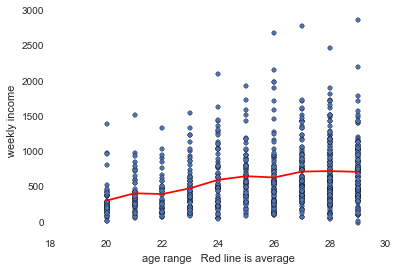

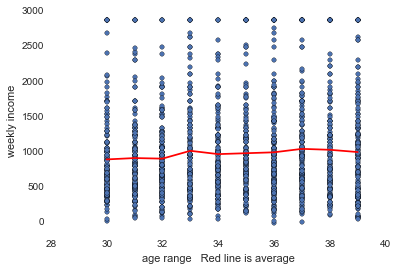

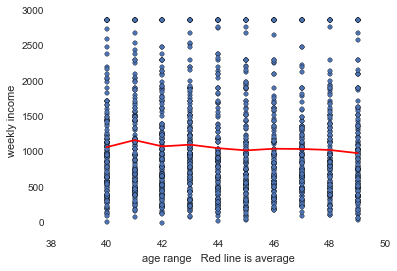

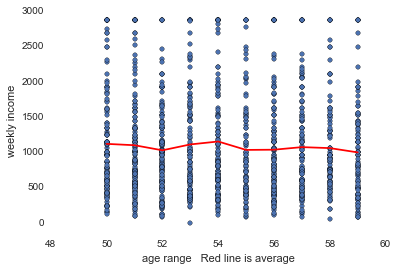

In [16]:
for item in increments:
    low_ages = item[0] <= summary.TEAGE
    high_ages = summary.TEAGE < item[1]
    
    values = (summary.loc[income & low_ages & high_ages])[['TRERNWA', 'TEAGE', 'TUFINLWGT']]
    values['TRERNWA'] = values['TRERNWA'].apply(lambda x: x/100)
    
    values.plot(kind='scatter', x='TEAGE', y='TRERNWA', yticks=range(0,3001)[::500])
    mn = values['TRERNWA'].mean()
    sd = values['TRERNWA'].std()

    #plt.axhline(y=mn)
    #plt.text(x=item[0] - 1, y=-300, s='mean weekly income: {}'.format(round(mn, 0)))
    plt.xlabel('age range   Red line is average') #standard deviation: {}'.format(round(sd, 2)))
    plt.ylabel('weekly income')
    
    averages = []
    idxs = []
    for idx in range(item[0], item[1]):
        age = summary.TEAGE == idx
        averages.append((values[age]['TRERNWA']).mean())
        idxs.append(idx)
    plt.plot(idxs, averages, color='r')
    plt.show()

## Hours worked vs Hourly wage

Correlation score:  0.196


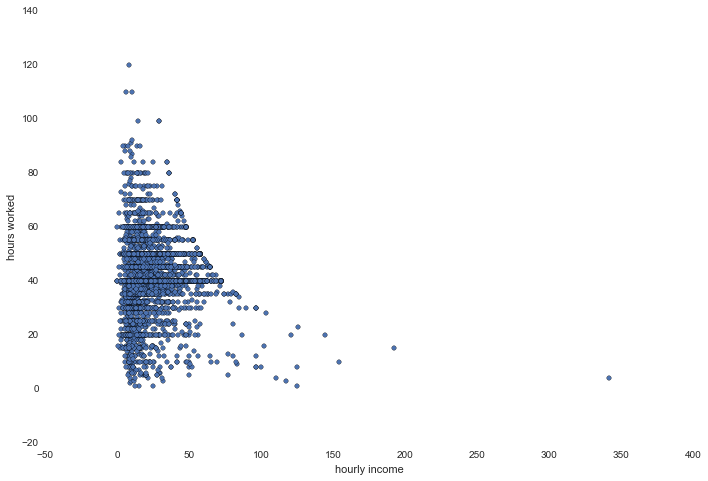

In [18]:
ages = (80 > summary.TEAGE) & (summary.TEAGE > 20)
values = (summary[income & ages & hours])[['TRERNWA', 'TEHRUSLT']]

values['TRERNWA'] = values['TRERNWA'].apply(lambda x: x/100) # convert to dollars
values['TRERNWA'] = values['TRERNWA']/values['TEHRUSLT'] # convert to hourly wage
    
    
values.plot(kind='scatter', x='TRERNWA', y='TEHRUSLT')

plt.ylabel('hours worked')
plt.xlabel('hourly income')
plt.subplots_adjust(bottom=1, top=2.5, left=1, right=2.5)
sbn.set_context('poster')

print('Correlation score: ', round(values['TEHRUSLT'].corr(values['TRERNWA'], 'spearman'), 3))

in 300 dollars/week bins:
-----------------------

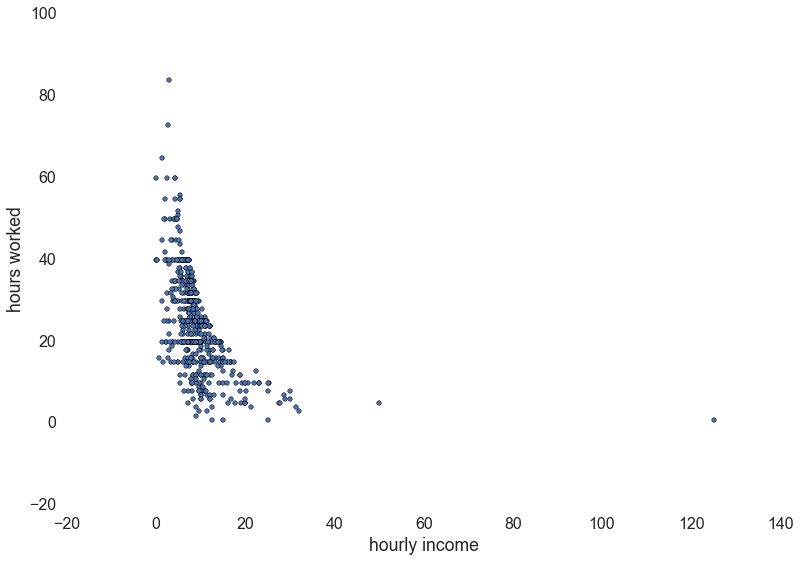

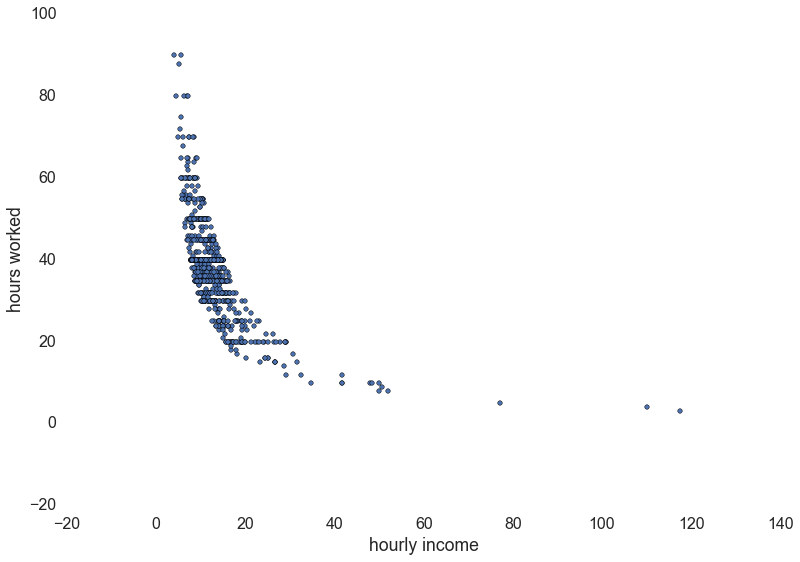

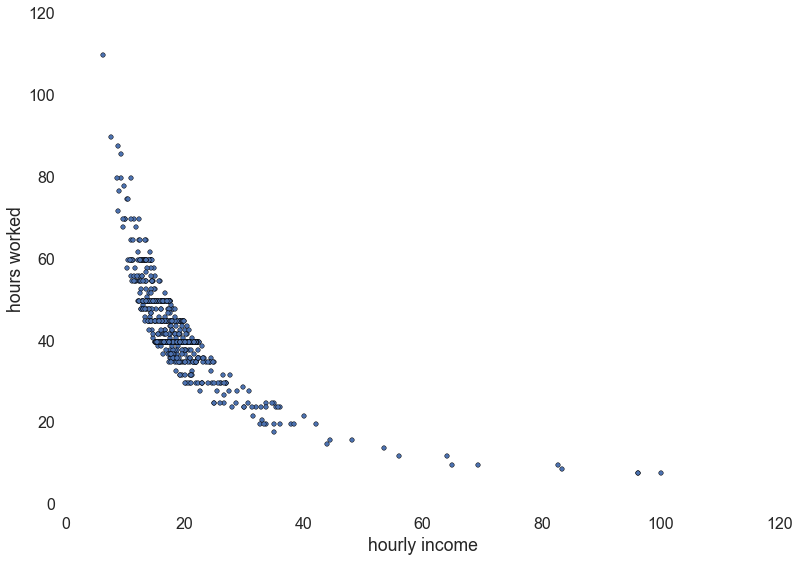

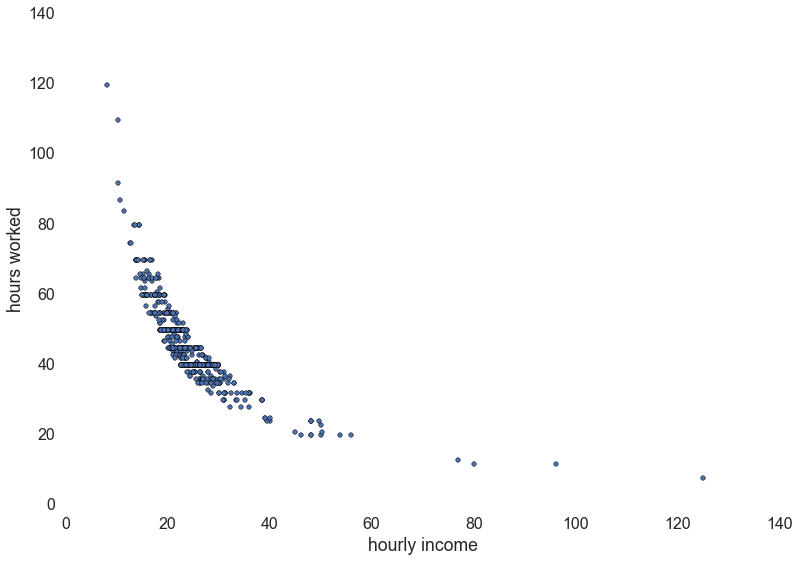

In [24]:
for idx in range(120000)[::30000]:
    ages = (80 > summary.TEAGE) & (summary.TEAGE > 20)
    income = (summary.TRERNWA < idx + 30000) & (summary.TRERNWA > idx)
    values = (summary[income & ages & hours])[['TRERNWA', 'TEHRUSLT']]

    values['TRERNWA'] = values['TRERNWA'].apply(lambda x: x/100)
    values['TRERNWA'] = values['TRERNWA']/values['TEHRUSLT']

    values.plot(kind='scatter', x='TRERNWA', y='TEHRUSLT')
    plt.ylabel('hours worked')
    plt.xlabel('hourly income')

    #print('Correlation score: ', round(values['TEHRUSLT'].corr(values['TRERNWA'], 'spearman'), 3))

the starting point of the bin doesn't matter:
---------------------------------------------

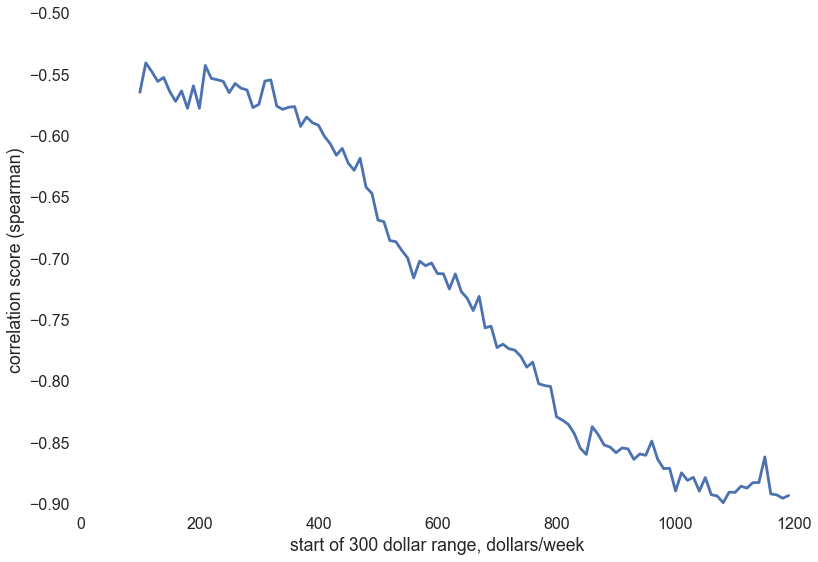

In [20]:
corr_score = []
ranges = []
for item in range(100, 1200)[::10]:
    
    ages = (80 > summary.TEAGE) & (summary.TEAGE > 20)
    income = (summary.TRERNWA < item * 100 + 30000) & (summary.TRERNWA > item * 100)
    values = (summary[income & ages & hours])[['TRERNWA', 'TEHRUSLT']]

    values['TRERNWA'] = values['TRERNWA'].apply(lambda x: x/100) # convert to dollars
    values['TRERNWA'] = values['TRERNWA']/values['TEHRUSLT']  # convert to hourly
    corr_score.append(values['TEHRUSLT'].corr(values['TRERNWA'], 'spearman'))
    ranges.append(item)
plt.plot(ranges, corr_score)
plt.xlabel('start of 300 dollar range, dollars/week')
plt.ylabel('correlation score (spearman)')

# hourly wages and hours worked are more negatively correlated for people who make more per week.